<a href="https://colab.research.google.com/github/MarceloTisera/AprendizajeNOSupervisado/blob/master/ETA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Calculo de ETA para una muestra hisotorica de un recorrido
En el presente trabajo se pretende calcular el tiempo estimado de arribo (por sus siglas en ingles ETA).
Para conseguir esto se diseno una red neuronal basada en el concepto de memoria a largo-corto plazo (por sus siglas en ingles LSTM). La estructura de la misma es mostrada y creada en el capitulo _2_ .

En el capitulo _1_ se hace un tratamiento muy simple a estos datos que estan en en un formato ".csv".

Para finalizar en el capitulo _3_ se ha hecho un analizis de los resultados contrastados con el problema para demostrar la robustez del metodo empleado.

# indice



1.   Estudiando el data set
2.   preparacion del data set, creacion de la red neuronal y entrenamiento 
3.   Analisis de resultados
4.   conclusion

# 1. estudiando el data set

En primer lugar se intentara omitir comentarios inecesarios como 'importacion delibrerias' y otros redundates.

El analisis comienza observando la estructura del data set, donde podemos ver que el data set posee una estructura algo redundante para nuestro caso. Nuestro problema corresponde a la estimacion de ETA. por consiguiente observemos los datos veamos que cosas son las mas relevantes.

In [ ]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from google.colab import drive
drive.mount('/content/drive')
asd = pd.read_csv('/content/drive/My Drive/jesper-hageri.csv')
asd.head()

Observando es claro las caracteristicas mas relevantes posiblemente sean "DistanceTraveled", "SecondsFromStart", debido a que con estas dos podemos obtener mas datos que son de nuestro interes como el ETA real y la velocidad media.

In [ ]:
asd.describe()

,AltitudeMeters,LatitudeDegrees,LongitudeDegrees,HeartRateBpm,SecondsFromStart,DistanceTraveled
count,503.000000,504.000000,504.000000,0.0,504.000000,504.000000
mean,73.274354,59.161502,24.693349,NaN,11118.898810,262247.710283
std,11.691429,0.047807,0.143985,NaN,6419.885247,169631.370011
min,41.000000,59.066290,24.432849,NaN,0.000000,0.000000
25%,65.000000,59.127487,24.595929,NaN,5493.250000,100248.302454
50%,75.000000,59.166730,24.704425,NaN,11376.500000,250983.020745
75%,83.000000,59.191633,24.781659,NaN,16618.500000,407703.497430
max,99.000000,59.269908,24.984918,NaN,21587.000000,562834.317733


Mirando el histograma de los datos no hay mucho que uno pueda resaltar en cuanto a lo que se pretende resolver.
Pero podemos decir cosas como:

El recorrido estudiado esta en una vecindad perteneciente al rango de longitud (24.5, 25), latutud(59.1, 59,3)

El movil sube y baja en su trayectoria pero mayoritariamente permanece en rangos de altura (70, 90) lamentablemente no tenemos las unidades. Pero una vez mas, estos datos parecen no ser necesarios.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66ebac2048>,
      dtype=object)

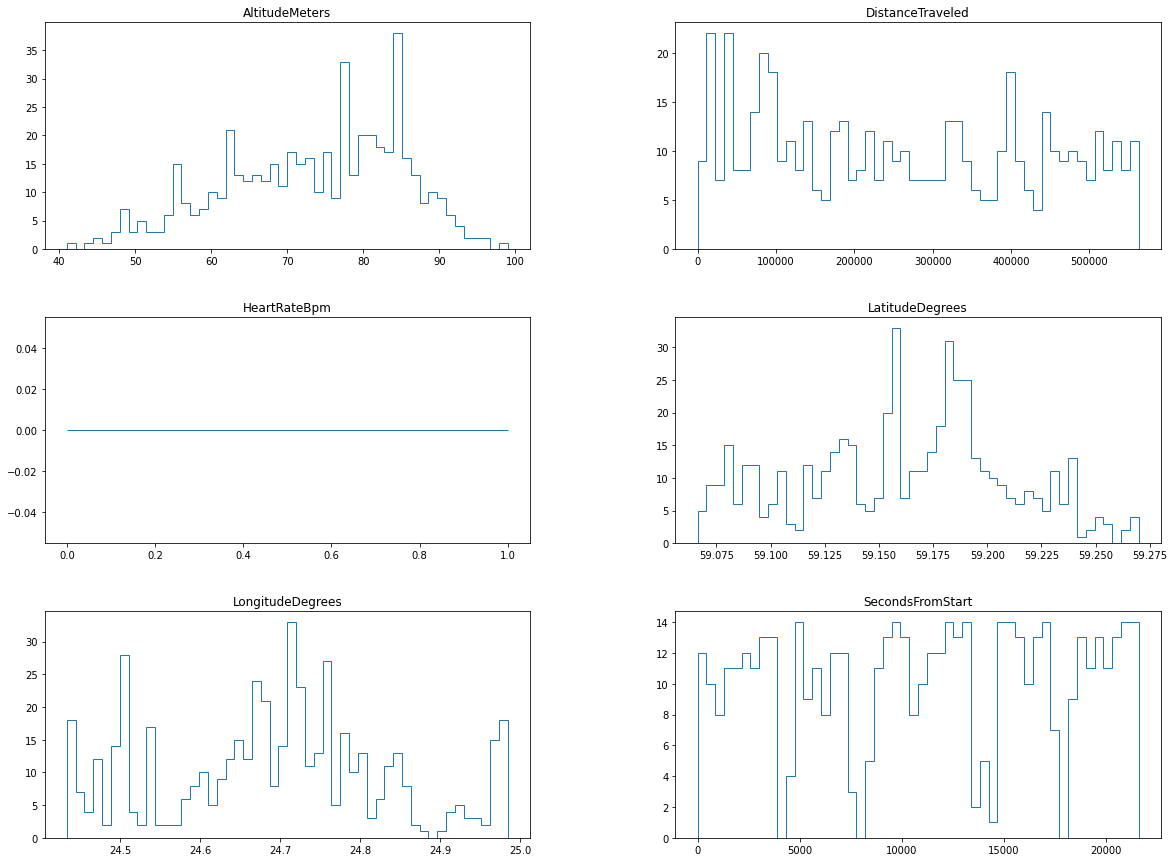

In [ ]:
asd.hist(bins=50, figsize=(20, 15), histtype='step', grid=False)


In [ ]:
asd['VelMedia'] = asd['DistanceTraveled'].diff() / asd['SecondsFromStart'].diff()
asd['ETA'] = asd['SecondsFromStart'][len(asd) - 1] - asd['SecondsFromStart']

Como se planteo previamente, el imput para este modelo a probar seria "Velocidad media", "Posicion" y "Tiempo total del recorrido"
donde esto debe ser contraaastado frente al valor real de "ETA". 

Entonces removes la la infroamcion que no es necesaria.

In [ ]:
del asd['AltitudeMeters'], asd['LatitudeDegrees'], asd['Time']
del asd['LongitudeDegrees'], asd['HeartRateBpm']
asd.head()


,SecondsFromStart,DistanceTraveled,VelMedia,ETA
0,0.0,0.000000,3.087495,21587.0
1,36.0,111.149837,3.087495,21551.0
2,66.0,2046.141467,64.499721,21521.0
3,97.0,4172.358649,68.587651,21490.0
4,128.0,6056.638388,60.783217,21459.0


Los valores "NaN" de la velocidad media los sustituimos por suvalor contiguo. Por simple aritmetica existe solo un valor NaN, que es el primero.

In [ ]:
asd['VelMedia'][0] = asd['VelMedia'][1]
asd.tail()

,SecondsFromStart,DistanceTraveled,VelMedia,ETA
499,21465.0,559175.986853,84.235269,122.0
500,21495.0,560564.167040,46.272673,92.0
501,21526.0,562268.075338,54.964784,61.0
502,21556.0,562661.067759,13.099747,31.0
503,21587.0,562834.317733,5.588709,0.0


Miremos la matriz de correlacion, simplemente vemos si existe algun sentido en nuestra eleccion

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66eb83cac8>,
      dtype=object)

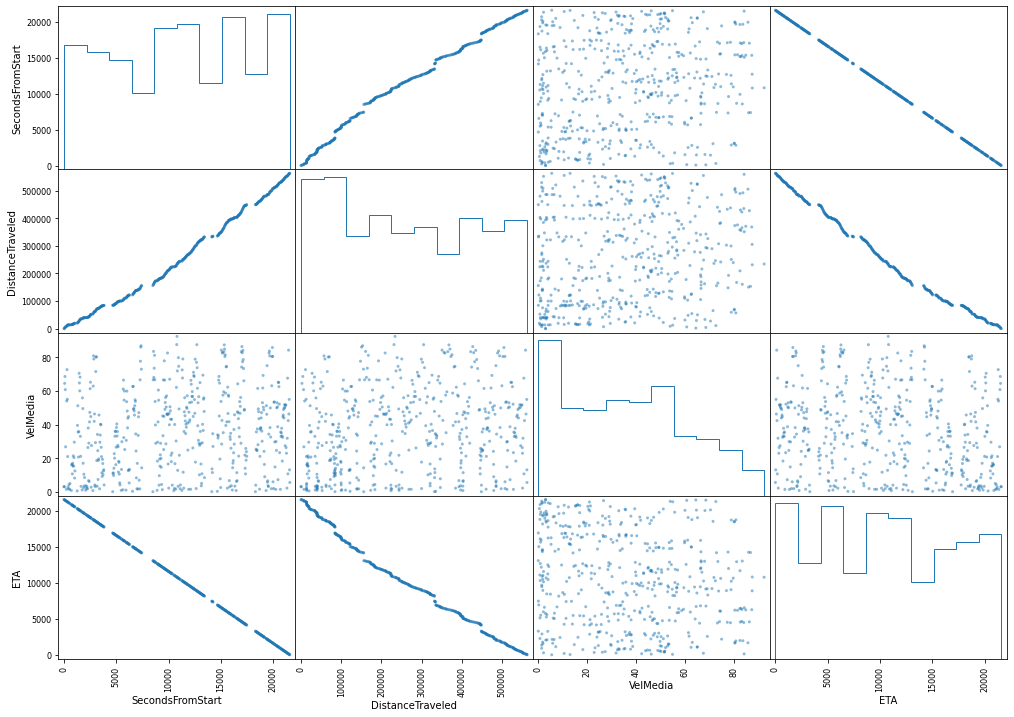

In [ ]:
scatter_matrix(asd, figsize=(17, 12), hist_kwds={'histtype': 'step'})

Obviamente, las variables mas correlacionadas son
ETA vs Distaancia, Distacia vs Tiempo de viaje.
Nada para sorprenderse. aunque podemos ver que la velocidad media no esta muy relacionada con las otras tres variables. Pero por cuestiones de "causalidad" debise ser fundamental debido a que una mayor velocidad media en un mayor tiempo implica mayor distancia recorida, esto sera muy importante para nuestro problema debido que las redes neuronales LSTM son capaces de comprender estas caracteristicas ya que no solo se fijan en el ultimo punto si no comprenden un orden temporal en los datos en si.

Siguiendo con el problema, miremos como se ve el grafico de Distance VS ETA

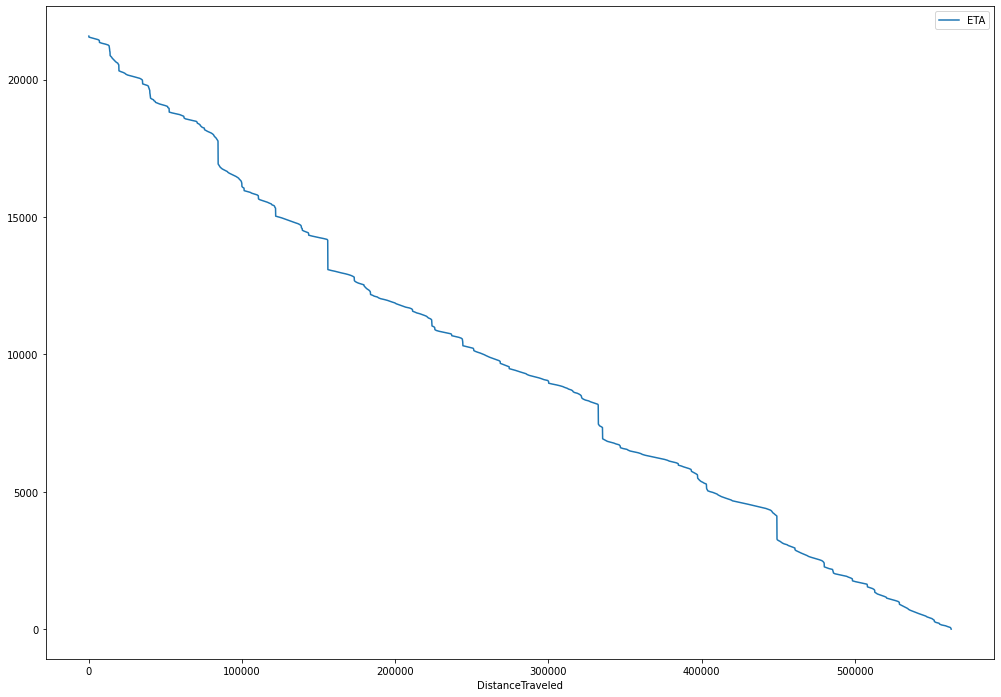

In [ ]:
asd.plot(x="DistanceTraveled", y="ETA", figsize=(17, 12))

Como se puede notar, existen ciertos pratones, y quizas algun defecto en los datos el cual desconozco, esto se intuye debido a esos "semi-picos" cada distancia intervalos. Evidentemente esto prodria producir un error extra a nuestra red. pero debiod a que no parece ser un error tan grosero, veremos que sucede. 

# 2. preparacion del data set, creacion de la red neuronal y entrenamiento

En primero lugar seccionamos los datos 80% entrenamiento y 20% validacion. 
En segundo lugar voy a estandarizar el conjunto de datos utilizando la media y la desviación estándar (para ambos conjuntos por separado)

In [ ]:
train, val = train_test_split(asd, test_size=0.2, shuffle=False)

train = train.values
data_mean = train.mean(axis=0)
data_std = train.std(axis=0)

train = (train-data_mean)/data_std

val = val.values
data_mean = val.mean(axis=0)
data_std = val.std(axis=0)

val = (val-data_mean)/data_std

Tome atencion en que estableci el parametro "shufle" en "False" por el simple hecho de que en esta clase de redes neuronales el orden es relevante.

Ahora para "cocinar" los datos y convertirlos en un data set para entrenamientos generare una ventana corrediza de (10, 3) donde 10 corresponde al historico, y 3 coresponde a las caracteristicas de cada historico.

A posteriori se generaran Batches de 10 de cada conjunto de datos, quedando asi batches con la forma (10,10,3). 
"cajas"(tensores) de 10x10x3

In [ ]:
def split_sequences(sequences, winzise):
    x, y = list(), list()
    for i in range(len(sequences)):
        # encuentra el final de este patron
        end_ix = i + winzise
        # revisameos si estamos fuera del rango de sequencias
        if len(sequences)-1 < end_ix:
            break
        # aramos los vectores de entrada y salida
        seq_x, seq_y = sequences[i:end_ix, :3], sequences[end_ix, 3]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)


x_train, y_train = split_sequences(train, 10)
x_val, y_val = split_sequences(val, 10)
x_train.shape
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().batch(10).repeat()

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.cache().batch(10).repeat()

En la celda siguien, podemos ver que quien hace el "trabajo sucio" son simples lineas de codigo. Aunque esta configuracion dio resultados bastante positivos como veremos mas adelantes.

Esto crea la red y luego la compilamos

In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(100, input_shape=(10, 3), return_sequences=True),
        tf.keras.layers.LSTM(100),
        tf.keras.layers.Dense(1)
                                ])
model.compile(optimizer='adam', loss='mse')

Comenzamos el entrenamiento y se ve claramente que los resultados van en buena direccion.

In [ ]:
history = model.fit(train_data, epochs=10, steps_per_epoch=200,
                    validation_data=val_data,
                    validation_steps=50)

NameError: ignored

# 3. Analisis de resultados
Miremos a ver que paso con nuestros resultados. Debido que pueden usarse multiples configuraciones para lograr otros resultados mejores o peores

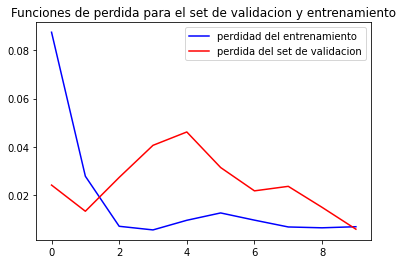

In [ ]:
def plot_train_history(history, titulo):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()
    plt.plot(epochs, loss, 'b', label='perdidad del entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='perdida del set de validacion')
    plt.title(titulo)
    plt.legend()
    plt.show()


plot_train_history(history, 'Funciones de perdida para el set de validacion y entrenamiento')

Los resultados parecen ser prometedores aunque podemos ver los resultados de otra forma.
con un histograma de "ETA real" vs "ETA predicho"

Text(0.5, 1.0, 'ETA real - ETA LSTM')

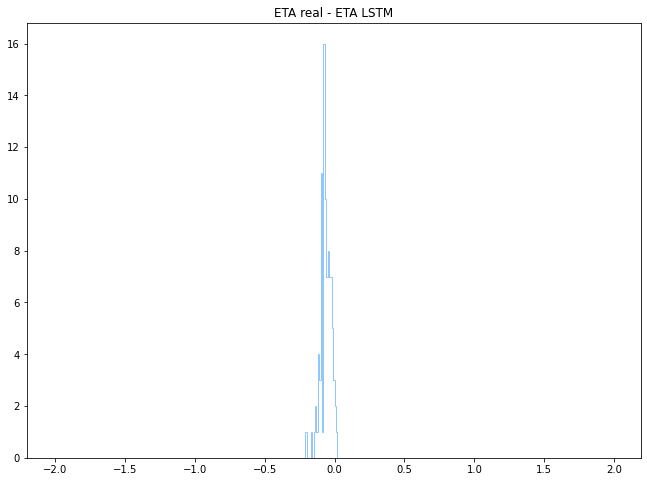

In [ ]:
a = np.reshape(y_val, (-1))
b = np.reshape(pre_val, (-1))
b.shape
plt.figure(figsize=(11,8))
plt.hist(a - b, np.arange(-2, 2, 0.01), histtype='step')
plt.title("ETA real - ETA LSTM")

Como se muestra en las figuras previas, los resultados son espectaculares para este problema en partiocular. Aunque se puede ser un poco mas explicito viendo los resultados en contexto.

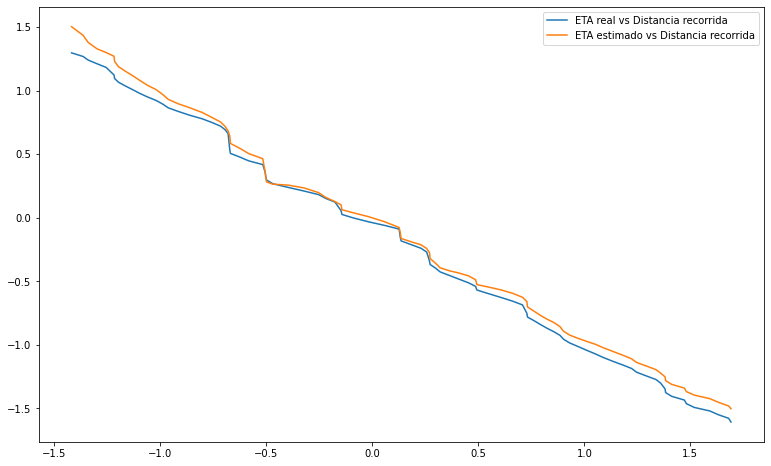

In [ ]:
ETA_real = []
ETA = []
distances = []
for test, real in zip(x_val, y_val):
    test_ = np.reshape(test, (1, 10, 3))
    dist = test_[:, -1, 1]
    eta = float(model(test_))
    ETA.append(eta)
    distances.append(dist)
plt.figure(figsize=(13,8))
plt.plot(distances, y_val, label='ETA real vs Distancia recorrida')
plt.plot(distances, ETA, label='ETA estimado vs Distancia recorrida')
plt.legend()

# Conclusiones

Segun el analisis hecho en el capitulo 3 del presente trabajo se logro probar que el metodo de para estimar ETA basado en redes neuronales tipo LSTM es muy potente. Con unos errores de calculos muy acetables como lo muestra el histograma (ETA Real - ETA LSTM) como tambien el grafico de arriba donde la linea "amarilla"
practicamente  se corresponde con la azul. Evidentemente este seria un resultado aplicable a algun sistema de gestion de trafico si se usara para estimar el ETA de multiples vehiculos.

Cesar Munoz A.